In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import yfinance as yf


In [2]:
# functions 

def GetIndexData(url, peirod):
    idx_comp = pd.read_html(url)
    idx_comp = idx_comp[0]
    idx_tickers = idx_comp['Symbol']
    
    l=[]
    ln=[]
    for t in idx_tickers:
        tmp = yf.Ticker(t)
        l.append(tmp.history(peirod))
        ln.append(t)
    data = dict(map(lambda t,d:(t,d), ln,l))
    data
    return data


def GetClosebySector(data, sector):
    l=[]
    for t in sector:
        l.append(data.get(t)['Close'])
    close = pd.concat(l, axis=1).set_axis(labels=sector, axis=1)
    return close


def ADF(df):
    import statsmodels.tsa.stattools as ts
    import datetime as dt
    from dateutil.relativedelta import relativedelta
    import statsmodels.api as sm
    
    lp=[]
    for i in range(df.shape[1]):
        lp.append(ts.adfuller(df.iloc[:,i])[1])
    dfAdfullerP = pd.DataFrame(lp, index = df.columns.to_list())
    dfAdfullerP['Stationarity'] = [1 if p<=0.01 else 0 for p in dfAdfullerP[0]]
    dfAdfullerP = dfAdfullerP.rename({0: 'P values'}, axis=1)
    return dfAdfullerP


def OLS(dfTrain, n1, n2, plot=False):

    train = dfTrain
    import statsmodels.api as sm
    n1= n1
    n2 = n2
    x = train.loc[:,n1]
    x_const = sm.add_constant(x)
    y = train.loc[:,n2]

    linear_reg = sm.OLS(y, x_const)

    res = linear_reg.fit()
    res.summary()
    
    beta = res.params[1]
    const = res.params[0]
    y_pred = beta * x + const
    
    dfSprd = pd.DataFrame(y - y_pred, index = dfTrain.index)
    dfSprd.columns = ['Spread']
    
    if plot:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(15,7))
        sc = plt.scatter(x,y, s = 50, c=x, marker='o', alpha=0.6, label = 'y')
        plt.plot(x, y_pred, '-', c='black', linewidth = 3, label = 'y_hat')
        plt.legend()
        plt.xlabel(n1)
        plt.ylabel(n2)


        dfSprd = pd.DataFrame(y - y_pred, index = dfTrain.index)
        dfSprd.columns = ['Spread']
        dfSprd.plot(figsize=(15,7))
    
    return res.params, res.summary(),dfSprd


def SpreadStationaryTest(dfLogP, n1, n2):
    import statsmodels.tsa.stattools as ts 
    stk1 = n1
    stk2 = n2
    x = dfLogP.loc[:,n1]
    x_const = sm.add_constant(x)
    y = dfLogP.loc[:,n2]
    linear_reg = sm.OLS(y,x_const)
    res = linear_reg.fit()
    beta = res.params[1]
    const = res.params[0]
    y_pred = x * beta + const
    spread = y - y_pred
    adf = ts.adfuller(spread, maxlag = 1)
    p = adf[1]
    if p<0.01:
        conintP = (stk1, stk2)
        pv = adf[1]
        return [conintP, pv, beta]
    # else:
    #     conintP = (stk1, stk2)
    #     pv = adf[1]
    #     return ['Nonstationary', pv, beta]


def TestAllPairsStationarity(dfLogP):
    tmp=[]
    lpv=[]
    lb=[]
    lCointP = []
    allstk = dfLogP.columns.to_list()
    n = len(allstk)
    for i in range(n):
        for j in range(i+1,n):
            tmp.append(SpreadStationaryTest(dfLogP,allstk[i], allstk[j]))
    lCointP = [x[0] for x  in tmp if x is not None]
    lpv = [x[1] for x in tmp if x is not None]
    lb = [x[2] for x in tmp if x is not None]
    res = pd.DataFrame({'P': lpv, 'Ratio': lb}, index = lCointP)
    return res  

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

spx_comp = pd.read_html(url)
spx_comp = spx_comp[0]
spx_tickers = spx_comp['Symbol']
#spx_tickers
dataSpx = GetIndexData(url, '5Y')

ERROR BRK.B: No data found, symbol may be delisted
ERROR BF.B: No price data found, symbol may be delisted (period=5y)


In [4]:
fin = spx_comp[spx_comp['GICS Sector']=='Financials']['Symbol']
closeFin = GetClosebySector(dataSpx,fin)
closeFin = closeFin.drop(columns = 'BRK.B')
closeFinLogret = np.log(closeFin/closeFin.shift(1))
closeFinLogret = closeFinLogret.tail(-1)
closeFinLogP = np.log(closeFin)

In [5]:
# Test on Log Price
ADF(closeFinLogP)

,P values,Stationarity
AFL,0.660873,0
ALL,0.267576,0
AXP,0.476540,0
AIG,0.325375,0
AMP,0.757388,0
...,...,...
USB,0.331373,0
V,0.290508,0
WFC,0.306300,0
WTW,0.356395,0


In [407]:
ADF(closeFinLogP)[ADF(closeFinLogP)['Stationarity']==0]
# conlucsion: testing on the past 5 years'log price of financial stocks. all non stationary

,P values,Stationarity
AFL,0.660873,0
ALL,0.267576,0
AXP,0.476539,0
AIG,0.325375,0
AMP,0.757388,0
...,...,...
USB,0.331373,0
V,0.290508,0
WFC,0.306300,0
WTW,0.356394,0


In [6]:
# we test for diff of log price
nsta_idx = ADF(closeFinLogP)[ADF(closeFinLogP)['Stationarity']==0].index.to_list()
nstaLogP = closeFinLogP.loc[:, nsta_idx]
nstaLogP

Symbol,AFL,ALL,AXP,AIG,AMP,AON,ACGL,AJG,AIZ,BAC,...,STT,SYF,TROW,TRV,TFC,USB,V,WFC,WTW,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-25 00:00:00-04:00,3.664064,4.398701,4.519389,3.850825,4.865729,4.879179,3.281287,4.116799,4.530441,3.233347,...,4.413707,3.386624,4.612774,4.701641,3.751678,3.743751,4.841270,3.843216,4.962700,3.846689
2018-06-26 00:00:00-04:00,3.662247,4.405119,4.516034,3.840071,4.844506,4.879542,3.273743,4.111512,4.518182,3.235452,...,4.410365,3.376221,4.603629,4.692710,3.746248,3.736209,4.853567,3.833346,4.955314,3.835645
2018-06-27 00:00:00-04:00,3.648748,4.384190,4.503225,3.825801,4.820442,4.859303,3.268428,4.092245,4.528001,3.224885,...,4.393381,3.362079,4.577587,4.682216,3.731755,3.728812,4.841957,3.830534,4.941442,3.817341
2018-06-28 00:00:00-04:00,3.644130,4.395640,4.503328,3.832398,4.821380,4.868080,3.274121,4.097635,4.552994,3.239997,...,4.396249,3.362382,4.578279,4.691323,3.730966,3.730627,4.855000,3.837082,4.952137,3.819600
2018-06-29 00:00:00-04:00,3.639723,4.394764,4.513894,3.828445,4.831367,4.875323,3.275634,4.100089,4.539176,3.223113,...,4.388225,3.373528,4.581817,4.690424,3.726811,3.738656,4.852812,3.870275,4.953853,3.810532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-15 00:00:00-04:00,4.245061,4.705377,5.157963,4.036362,5.785639,5.802300,4.250636,5.364246,4.857873,3.379974,...,4.312811,3.509753,4.742233,5.170314,3.472587,3.505257,5.421287,3.746205,5.449621,3.366606
2023-06-16 00:00:00-04:00,4.240319,4.711061,5.148715,4.048301,5.783825,5.797212,4.264931,5.364947,4.878550,3.373826,...,4.300952,3.493473,4.737776,5.174736,3.462606,3.510052,5.433329,3.741946,5.459586,3.354455
2023-06-20 00:00:00-04:00,4.216562,4.687763,5.132322,4.026779,5.774955,5.795906,4.259718,5.354887,4.862986,3.362803,...,4.292649,3.487681,4.722509,5.167981,3.445214,3.513931,5.422612,3.735047,5.449492,3.326833


In [7]:
dif_nstaLogP = nstaLogP.diff().dropna()
dfAdfDif = ADF(dif_nstaLogP)
dfAdfDif
# we can see log price is I(1)


,P values,Stationarity
AFL,1.254596e-15,1
ALL,1.690997e-16,1
AXP,3.911263e-26,1
AIG,1.318481e-16,1
AMP,2.664912e-18,1
...,...,...
USB,2.710253e-12,1
V,1.783371e-20,1
WFC,1.140622e-19,1
WTW,1.259503e-20,1


In [8]:
# we run linear regression on one sample pair.
dfAdfDif.sort_values(by='P values', ascending=True)

,P values,Stationarity
MKTX,0.000000e+00,1
AXP,3.911263e-26,1
DFS,6.433602e-26,1
MTB,5.652339e-24,1
FITB,1.841893e-23,1
...,...,...
SPGI,9.216971e-14,1
AON,3.510137e-13,1
PYPL,1.515533e-12,1
USB,2.710253e-12,1


<Axes: xlabel='Date'>

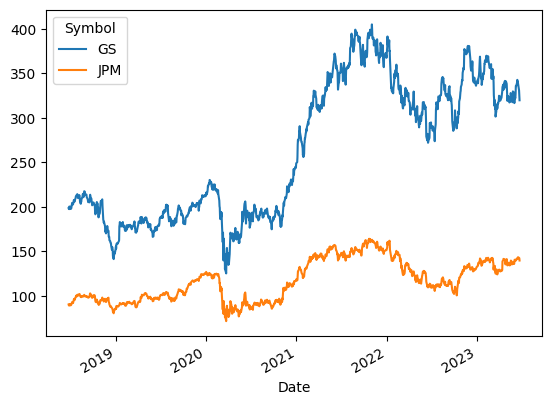

In [9]:
closeFin.loc[:,['GS', 'JPM']].plot()

In [10]:
# split train and test data: 3:2
train = closeFinLogP.iloc[:883,:]
test = closeFinLogP.iloc[883:,:]

In [11]:
res = TestAllPairsStationarity(closeFinLogP)
res.sort_values(by='P')

,P,Ratio
"(ACGL, RE)",9.041774e-07,0.713928
"(MCO, SPGI)",1.467379e-05,1.002299
"(BAC, PNC)",2.402364e-05,1.045150
"(MA, WTW)",2.671159e-05,0.748197
"(V, WTW)",2.942880e-05,0.905914
...,...,...
"(RJF, RF)",9.797054e-03,0.784513
"(AXP, CINF)",9.801457e-03,0.839253
"(AXP, CBOE)",9.812513e-03,0.412023
"(BRO, MA)",9.850625e-03,0.626400


<Axes: xlabel='Date'>

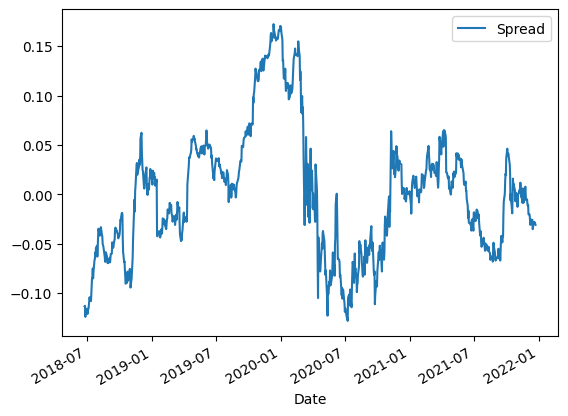

In [20]:
# We back test on GS and JPM
n1 = 'GS'
n2 = 'JPM'
dfSprd = OLS(train, n1, n2)[2]
dfSprd.plot()


In [21]:
u = np.mean(dfSprd)
std = np.std(dfSprd)
thres = 2.32
x_t = test.loc[:,n1]
y_t = test.loc[:,n2]
beta = OLS(train, n1, n2)[0][1]
const = OLS(train, n1, n2)[0][0]

sprd_t = y_t - (beta * x_t + const)
lposY=np.zeros((len(sprd_t),))
lposX=np.zeros((len(sprd_t),))

dfBacktest = pd.DataFrame({'Spread': sprd_t,'y_t':y_t, 'x_t': x_t, 'Pos_y_t': lposY, 'Pos_x_t': lposX})

In [22]:
le = np.zeros((len(sprd_t),))
up = (u + thres * std).values
low = (u - thres * std).values
for i in range(dfBacktest.shape[0]-1):
    le[i] = y_t[i] - (beta * x_t[i] + const)

In [23]:

if le[0] > up:
    dfBacktest['Pos_y_t'][0] = -1
    dfBacktest['Pos_x_t'][0] = 1
elif le[0] > low:
    dfBacktest['Pos_y_t'][0] = 1
    dfBacktest['Pos_x_t'][0] = -1
else:
    dfBacktest['Pos_y_t'][0] = -1
    dfBacktest['Pos_x_t'][0] = 1

for i in range(1, dfBacktest.shape[0]-1):
    if min(le[i-1], le[i]) > up and le[i-1] < le[i]:
        dfBacktest['Pos_y_t'][i+1] = -1
        dfBacktest['Pos_x_t'][i+1] = 1
    elif max(le[i-1], le[i]) < low and le[i-1] > le[i]:
        dfBacktest['Pos_y_t'][i+1] = 1
        dfBacktest['Pos_x_t'][i+1] = -1
    elif (le[i-1] > le[i] and le[i-1]> u) or (le[i-1] < le[i] and le[i-1] < u):
        dfBacktest['Pos_y_t'][i+1] = -1 * dfBacktest['Pos_y_t'][i]
        dfBacktest['Pos_x_t'][i+1] = -1 * dfBacktest['Pos_x_t'][i]        
    else:
        dfBacktest['Pos_y_t'][i+1] = dfBacktest['Pos_y_t'][i] 
        dfBacktest['Pos_x_t'][i+1] = dfBacktest['Pos_x_t'][i]       

In [24]:
dfBacktest['Port'] = -1 * dfBacktest['Pos_y_t'] * y_t -1 * dfBacktest['Pos_x_t'] * x_t
dfBacktest['Port']
dfBacktest['PnL'] = dfBacktest['Port'].cumsum()
dfBacktest['Return'] = dfBacktest['PnL']/dfBacktest['PnL'].shift(1)-1

<Axes: xlabel='Date'>

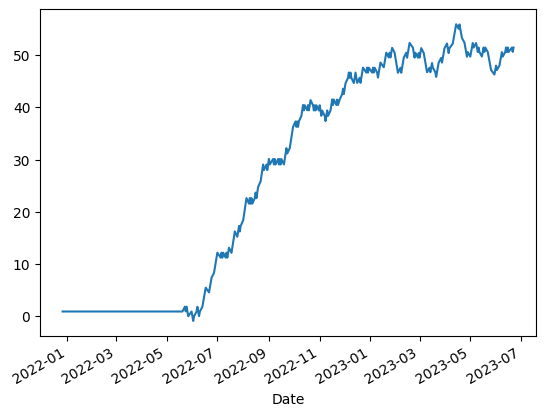

In [25]:
# Pnl if we invest +- 1 unit
dfBacktest['PnL'].plot()
